In [1]:
from so3_modelnet import *

In [2]:
test_dataset = ModelNet10Dataset(mode='Test')

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

908it [00:11, 82.38it/s] 


In [3]:
device = torch.device('cuda:5')
classifier = SO3Network()
classifier.to(device)
classifier.load_state_dict(torch.load('so3_ModelNet10_best_model.pth', map_location=device))

<All keys matched successfully>

In [4]:
invariant_features_ls = []
equivariant_features_ls = []
labels_ls = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classifier.input_features(inputs.permute(0, 2, 1).contiguous())
        outputs = outputs.permute(0, 2, 1).contiguous()
        outputs = classifier.feat(outputs)
        equivariant_features_ls.append(outputs)
        outputs = classifier.fc[0](outputs)
        invariant_features_ls.append(outputs)
        labels_ls.append(labels)

In [5]:
invariant_features = torch.cat(invariant_features_ls, dim=0)
invariant_features.shape

torch.Size([908, 40])

In [6]:
equivariant_features = torch.cat(equivariant_features_ls, dim=0)
equivariant_features.shape

torch.Size([908, 80])

In [7]:
labels = torch.cat(labels_ls, dim=0)
labels = labels.squeeze()
labels.shape

torch.Size([908])

In [8]:
invariant_features = invariant_features.cpu().numpy()
equivariant_features = equivariant_features.cpu().numpy()
labels = labels.cpu().numpy()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

num_classes = 10

# 数据标准化
# scaler = StandardScaler()
# invariant_features = scaler.fit_transform(invariant_features)
# equivariant_features = scaler.fit_transform(equivariant_features)

colors = ListedColormap(plt.cm.get_cmap("tab10").colors[:num_classes])

/tmp/ipykernel_412094/2548196638.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = ListedColormap(plt.cm.get_cmap("tab10").colors[:num_classes])


In [10]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)

invariant_features_tsne = tsne.fit_transform(invariant_features)
equivariant_features_tsne = tsne.fit_transform(equivariant_features)

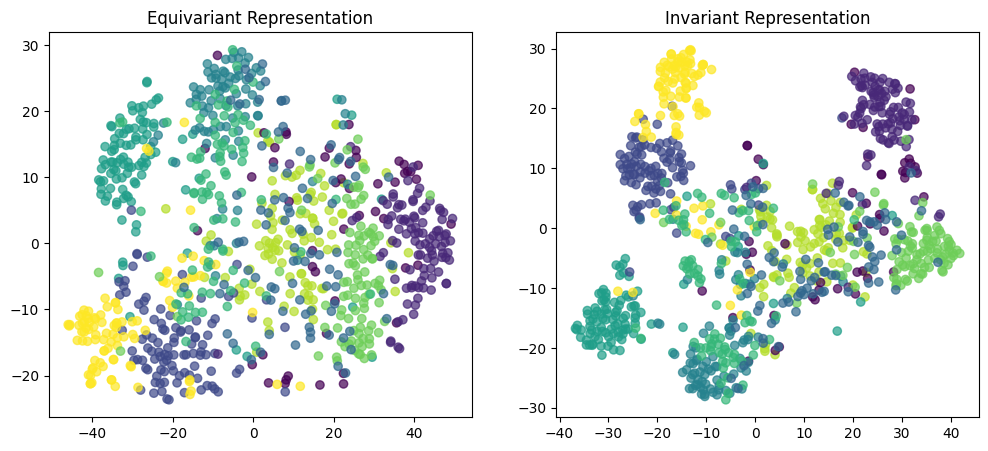

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(equivariant_features_tsne[:, 0], equivariant_features_tsne[:, 1], c=labels, alpha=0.7)
plt.xlabel("")
plt.ylabel("")
plt.title("Equivariant Representation")

plt.subplot(1, 2, 2)
plt.scatter(invariant_features_tsne[:, 0], invariant_features_tsne[:, 1], c=labels, alpha=0.7)
plt.xlabel("")
plt.ylabel("")
plt.title("Invariant Representation")

plt.show()

**Figure 1: Visualizing rotated ModelNet10 images via their equivariant representation (left) hides structure that is apparent in an invariant representation of the same latent codes (right).**

In [12]:
pca1 = KernelPCA(n_components=2)
pca2 = KernelPCA(n_components=2)

invariant_features_pca = pca2.fit_transform(invariant_features)
equivariant_features_pca = pca1.fit_transform(equivariant_features)

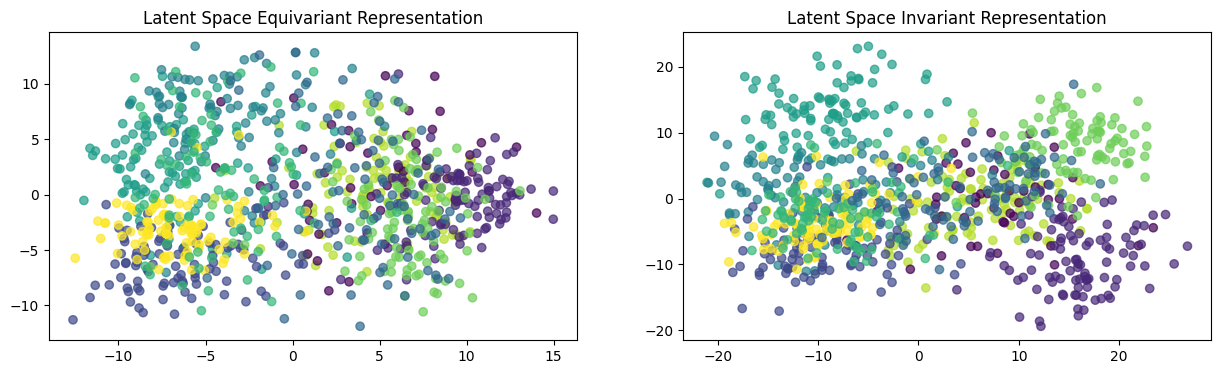

In [13]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.scatter(equivariant_features_pca[:, 0], equivariant_features_pca[:, 1], c=labels, alpha=0.7)
plt.xlabel("")
plt.ylabel("")
plt.title("Latent Space Equivariant Representation")

plt.subplot(1, 2, 2)
plt.scatter(invariant_features_pca[:, 0], invariant_features_pca[:, 1], c=labels, alpha=0.7)
plt.xlabel("")
plt.ylabel("")
plt.title("Latent Space Invariant Representation")

plt.show()

**Figure 9: The figure shows the first two principal components of the ModelNet10 training data for the equivariant representation
(right), and the invariant representation (left) of the latent space. The colours represent the classifier labels.**

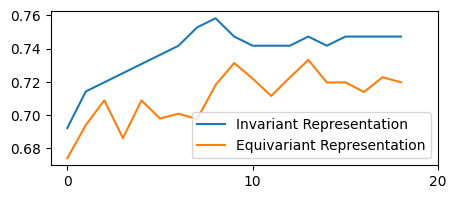

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score

# 对不变特征进行分析
X_train_eq, X_test_eq, y_train_eq, y_test_eq = train_test_split(
    invariant_features, labels, test_size=0.2, random_state=42
)

invariant_f1_scores = []

for n in range(2, 21):
    knn = KNeighborsClassifier(n_neighbors=n, weights='distance', leaf_size=50)
    knn.fit(X_train_eq, y_train_eq)
    y_pred_eq = knn.predict(X_test_eq)
    invariant_f1_scores.append(f1_score(y_test_eq, y_pred_eq, average='micro'))

# 对等变特征进行分析
X_train_eq, X_test_eq, y_train_eq, y_test_eq = train_test_split(
    equivariant_features, labels, test_size=0.2, random_state=42
)

equivariant_f1_scores = []

for n in range(2, 21):
    knn = KNeighborsClassifier(n_neighbors=n, weights='distance', leaf_size=50)
    knn.fit(X_train_eq, y_train_eq)
    y_pred_eq = knn.predict(X_test_eq)
    equivariant_f1_scores.append(f1_score(y_test_eq, y_pred_eq, average='weighted'))

plt.figure(figsize=(5, 2))
plt.plot(range(19), invariant_f1_scores, label='Invariant Representation')
plt.plot(range(19), equivariant_f1_scores, label='Equivariant Representation')
plt.xticks([0, 10, 20])
plt.legend()
plt.show()

**Figure 8: ModelNet10 dataset classification problem: F1 score
of KNN classifier applied to Invariant and Equivariant representations of the latent space.**